### Transfer Learning VGG16 unfreeze des 8 dernières couches, compilation SGD
> Reprise du modèle entrainé sur la classification

In [9]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import cv2
import seaborn as sns

import pandas as pd
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping
from sklearn import metrics
import gradcam
from sklearn.svm import SVC

In [2]:
src_img = '../images_mendeley/dataset_redim/'

#### Récupération de la base d'images et création jeu d'évaluation, de test et d'entrainement

In [3]:
data = pd.read_csv('../mendeley_cells_redim.csv',index_col=0)
data_train, data_eval = train_test_split(data,test_size=0.2,random_state=123)
data_train, data_test = train_test_split(data_train,test_size=0.2,random_state=123)

#### Utilisation d'un ImageDataGenerator sans transformation pour simplement redimensionné les images en 224*224 et chargé depuis un path

In [4]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = data_generator.flow_from_dataframe(data_train, directory=src_img, x_col='filename',y_col='category',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32)

test_generator = data_generator.flow_from_dataframe(data_test, directory=src_img, x_col='filename',y_col='category',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32)

Found 10938 validated image filenames belonging to 8 classes.
Found 2735 validated image filenames belonging to 8 classes.


In [5]:
# Création Callback pour stopper si pas stagnation
callback = EarlyStopping(monitor='val_loss', patience=2)

###### Récupération du modèle entrainé sur la classification

In [6]:
from keras.models import load_model
# load model
model = load_model('vgg16')

In [7]:
base_model = model.layers[0]

#### Freeze les couches de VGG16  sauf les 8 dernières pour affiner les poids du modèle
> Optimizer SGD avec learning rate à 1e-4  et momentum 0.9

In [10]:
# Freeze les couches VGG19, sauf les 8 dernières
for layer in base_model.layers[:-8]: 
    layer.trainable = False
    
model.compile(optimizer=SGD(learning_rate=1e-4, momentum=0.9), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, epochs = 16,batch_size = 32, validation_data = test_generator,callbacks=[callback])

Epoch 1/16
342/342 [==============================] - 6406s 19s/step - loss: 0.1667 - accuracy: 0.9483 - val_loss: 0.0725 - val_accuracy: 0.9766
Epoch 2/16
342/342 [==============================] - 6260s 18s/step - loss: 0.0422 - accuracy: 0.9866 - val_loss: 0.0599 - val_accuracy: 0.9795
Epoch 3/16
342/342 [==============================] - 6261s 18s/step - loss: 0.0166 - accuracy: 0.9953 - val_loss: 0.0512 - val_accuracy: 0.9828
Epoch 4/16
342/342 [==============================] - 6246s 18s/step - loss: 0.0054 - accuracy: 0.9987 - val_loss: 0.0555 - val_accuracy: 0.9835
Epoch 5/16
342/342 [==============================] - 6358s 19s/step - loss: 0.0017 - accuracy: 0.9999 - val_loss: 0.0430 - val_accuracy: 0.9883
Epoch 6/16
342/342 [==============================] - 6087s 18s/step - loss: 6.9526e-04 - accuracy: 1.0000 - val_loss: 0.0437 - val_accuracy: 0.9883
Epoch 7/16
342/342 [==============================] - 6157s 18s/step - loss: 4.8320e-04 - accuracy: 1.0000 - val_loss: 0.0440 

In [11]:
model.save('vgg16_fine_tunning_SGD')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: vgg16_8_SGD\assets


#### Prédictions sur données évaluations

In [12]:
eval_generator = data_generator.flow_from_dataframe(data_eval, directory=src_img, x_col='filename',y_col='category',class_mode ='sparse',target_size=(224,224),
                                              batch_size=32,shuffle=False)
predict = model.predict(eval_generator)

Found 3419 validated image filenames belonging to 8 classes.


In [13]:
model.evaluate(eval_generator,batch_size=32)

107/107 [==============================] - 890s 8s/step - loss: 0.0665 - accuracy: 0.9830


[0.06651607155799866, 0.9830359816551208]

> Amélioration du score : 98.3%

In [14]:
#Classes prédites
eval_predict_class = predict.argmax(axis = 1)
lst_classes = [key for key, val in eval_generator.class_indices.items()]
eval_predict_class_name = [lst_classes[i] for i in eval_predict_class]
eval_class_name = [lst_classes[i] for i in eval_generator.classes]
print(metrics.classification_report( eval_class_name,eval_predict_class_name ))

              precision    recall  f1-score   support

    basophil       0.99      0.99      0.99       222
  eosinophil       0.99      0.99      0.99       627
erythroblast       0.98      0.99      0.98       311
          ig       0.96      0.97      0.97       590
  lymphocyte       0.98      0.97      0.97       236
    monocyte       0.98      0.97      0.98       302
  neutrophil       0.98      0.98      0.98       682
    platelet       1.00      1.00      1.00       449

    accuracy                           0.98      3419
   macro avg       0.98      0.98      0.98      3419
weighted avg       0.98      0.98      0.98      3419



> Score de 97% sur les IG avec precision 96% et recall à 97% : nette amélioration
>
> Amélioration score monocyte également

#### Matrice de confusion

In [15]:
pd.crosstab(pd.Series(eval_class_name, name='Réalité'),pd.Series(eval_predict_class_name, name='Prédiction'))

Prédiction,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
Réalité,,,,,,,,
basophil,220,0,0,2,0,0,0,0
eosinophil,0,622,1,2,1,0,1,0
erythroblast,0,0,307,1,1,0,1,1
ig,1,0,1,573,0,4,11,0
lymphocyte,1,0,3,2,229,1,0,0
monocyte,0,2,0,3,3,294,0,0
neutrophil,0,2,1,11,0,0,667,1
platelet,0,0,0,0,0,0,0,449


> Confusion IG et neutrophil : tout à fait compréhensible, IG étant très souvent des cellules immatures neutrophil

### GRAD CAM

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 2056      
Total params: 15,898,184
Trainable params: 14,162,696
Non-trainable params: 1,735,488
__________________________________

In [17]:
# Reconstruit le modèle car problème de base_model avec GradCam
x = base_model.output
x = model.get_layer('global_average_pooling2d_1')(x)
x = model.get_layer('dense_4')(x)
x = model.get_layer('dense_5')(x)
x = model.get_layer('dense_6')(x)
x = model.get_layer('dense_7')(x)

In [18]:
model = Model(inputs = base_model.input, outputs = x)

In [19]:
img_size = (224, 224)
last_conv_layer_name = "block5_conv3"
# Remove last layer's softmax
model.layers[-1].activation = None

##### Basophil

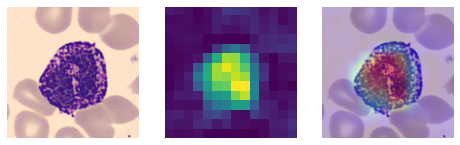

In [20]:
gradcam.display_headmap(preprocess_input, src_img + 'N_BA_200697.jpg', img_size, model, last_conv_layer_name,pred_index=0)

##### Eosinophil

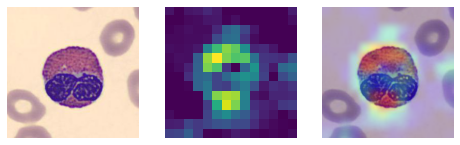

In [21]:
gradcam.display_headmap(preprocess_input, src_img + 'N_EO_40758.jpg', img_size, model, last_conv_layer_name,pred_index=1)

##### Erythroblast

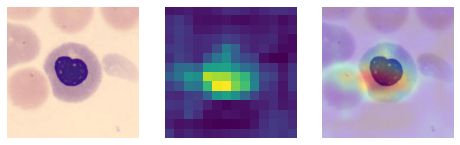

In [22]:
gradcam.display_headmap(preprocess_input, src_img +'N_ERB_80122.jpg', img_size, model, last_conv_layer_name,pred_index=2)

##### IG

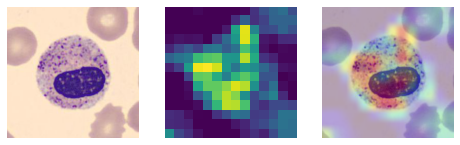

In [23]:
gradcam.display_headmap(preprocess_input, src_img +'N_MMY_19855.jpg', img_size, model, last_conv_layer_name,pred_index=3)

##### Lymphocyte

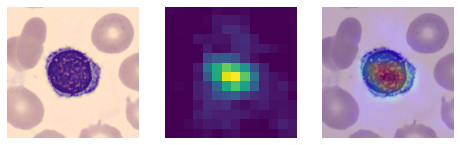

In [24]:
gradcam.display_headmap(preprocess_input, src_img+'N_LY_99706.jpg', img_size, model, last_conv_layer_name,pred_index=4)

##### Monocyte

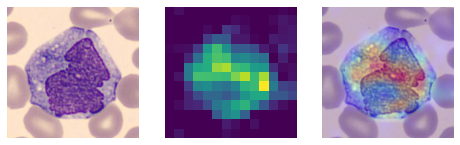

In [25]:
gradcam.display_headmap(preprocess_input, src_img+'N_MO_60562.jpg', img_size, model, last_conv_layer_name,pred_index=5)

##### Neturophil

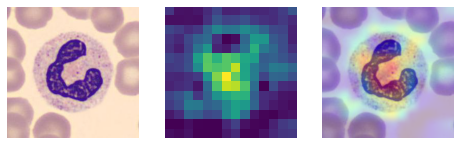

In [26]:
gradcam.display_headmap(preprocess_input, src_img+'N_BNE_53394.jpg', img_size, model, last_conv_layer_name,pred_index=6)

##### Platelet

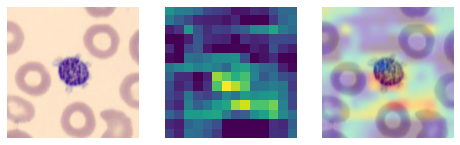

In [27]:
gradcam.display_headmap(preprocess_input, src_img+'N_PLATELET_4736.jpg', img_size, model, last_conv_layer_name,pred_index=7)